# 42186 - Model-based Machine Learning Project
## Group 12

------

### This notebook seek to analyse and model outpatient activity and visit duration at Rigshospitalet.

First the following packages, scripts and data has to be loaded

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam


# RUN THE SCRIPT Preprocess_data.py ONE TIME
# load data CaseRigshospitalet_optimized.parquet
df = pd.read_parquet('data/CaseRigshospitalet_optimized.parquet')

with open("Embedding/diagnosis_code_embeddings.pkl", "rb") as f:
    code_embeddings = pickle.load(f)
    df["embedded"] = df["Aktionsdiagnosekode"].map(code_embeddings)

/Users/signeolsen/opt/anaconda3/envs/MachineLearning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Content
* Visualization of the data
* PGM using diagnostic
* PGM using patient profile

## Visualization of the data


In [2]:
df.head()

,Patient ID,Patientkontakt ID,Patient alder på kontaktstart tidspunkt,Kontakt startdato,Kontakt slutdato,Kontakttype,Indlæggelsesmåde,Patientkontakttype,Aktionsdiagnosekode,Bidiagnosekode,...,Procedure udført,Behandlingskontakt ID,Besøgstype,Patient køn,Patient civilstand,Patient oprettet på Min SP (J/N),Patient land,Patient region,Patient postnummer,Patient kommune
0,Z4115614,1301023075465,0,2023-01-13 12:32:00,2023-01-13 13:02:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,,...,2023-01-13 12:32:00,176.794.528,OBST EFTERFØDSEL 30,Mand,Ugift,J,Danmark,Hovedstaden (84),2100,København
1,Z4115614,1301023121831,0,2023-01-15 13:27:00,2023-01-15 13:57:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,,...,2023-01-15 13:27:00,177.035.032,OBST EFTERFØDSEL 30,Mand,Ugift,J,Danmark,Hovedstaden (84),2100,København
2,Z4119225,1301023357249,0,2023-01-30 10:20:00,2023-01-30 10:50:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,,...,2023-01-30 10:20:00,178.269.449,OBST EFTERFØDSEL 30,Mand,Ugift,J,Danmark,Hovedstaden (84),2100,København
3,Z4127033,1301023443807,0,2023-02-04 12:46:00,2023-02-04 13:16:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,,...,2023-02-04 12:46:00,178.703.583,OBST EFTERFØDSEL 30,Mand,Ugift,J,Danmark,Hovedstaden (84),2100,København
4,Z4127033,1301023443875,0,2023-02-05 12:22:00,2023-02-05 12:52:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,,...,2023-02-05 12:22:00,178.703.779,OBST EFTERFØDSEL 30,Mand,Ugift,J,Danmark,Hovedstaden (84),2100,København


0          0.50
1          0.50
2          0.50
3          0.50
4          0.50
           ... 
4658061    0.82
4658062    0.68
4658063    0.63
4658064    0.63
4658065    0.63
Name: Kontakt varighed (timer), Length: 4658066, dtype: float32

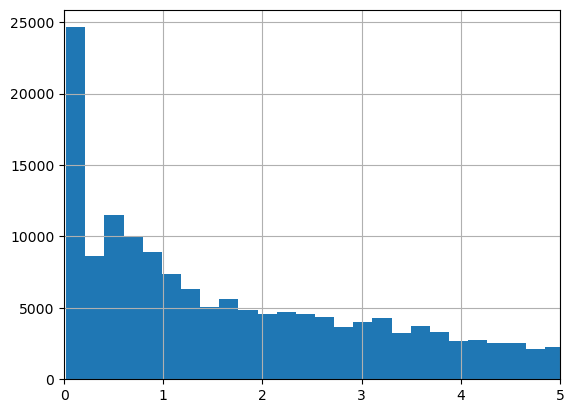

In [37]:
# Historgram where df['Kontakt varighed (timer)']<10
df_plot = df[df['Indlæggelsesmåde'] == 'Akut']
df_plot['Kontakt varighed (timer)'].hist(bins=1000)
plt.xlim(0, 5)

df['Kontakt varighed (timer)']

## PGM using diagnostic

In [2]:
# Map embeddings
df["embedded"] = df["Aktionsdiagnosekode"].map(code_embeddings)
df = df[df["embedded"].notnull()]

# Convert list of lists to a 2D NumPy array
embeddings = np.array(df["embedded"].tolist(), dtype=np.float32)

# Convert to PyTorch tensor
embedding_tensor = torch.from_numpy(embeddings)

In [56]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# Assume:
# - embedding_tensor: shape [N, D], a torch.Tensor
# - df['Kontakt varighed (timer)']: target values

# 1. Convert target to numpy
y_all = df['Kontakt varighed (timer)'].values.astype(np.float32)

# 2. Randomly select 1000 indices
total_samples = 100000
all_indices = np.arange(len(embedding_tensor))
selected_indices = np.random.choice(all_indices, size=total_samples, replace=False)

# 3. Subset the data
X_subset = embedding_tensor[selected_indices]
y_subset = torch.tensor(y_all[selected_indices], dtype=torch.float32)

# 4. Split into train/test (e.g. 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

1) Draw $\beta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

2) Draw $\eta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

3) For each patient, $p$, in $P$

    a) Draw $v_p \sim \text{LogNormal}(\beta^T\mathbb{x}_p, \eta^T \mathbb{x}_p)$


In [57]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
import pyro.poutine as poutine

# ==== Set random seed for reproducibility ====
pyro.set_rng_seed(0)

# ==== Simulated Data ====
P, D = X_train.shape
true_beta = torch.randn(D)
true_eta = torch.randn(D)

X = X_train
y = y_train

# ==== Models ====
def log_normal(data, targets=None):
    P, D = data.shape

    # Prior over beta
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.tensor(1.0)  # Fixed scalar standard deviation
        pyro.sample("obs", dist.LogNormal(loc, scale), obs=targets)


def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 0.1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 0.1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.exp(data @ eta)  # Ensure positivity
        pyro.sample("v", dist.LogNormal(loc, scale), obs=targets)

# ==== Guide ====
guide = AutoNormal(log_normal)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(log_normal, guide, optimizer, loss=elbo)

n_steps = 3000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean = posterior["beta"]
#eta_mean = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean[:5])
#print("Posterior mean of eta (first 5 dims):", eta_mean[:5])


[0] ELBO: 274196.50
[500] ELBO: 149104.34
[1000] ELBO: 127627.13
[1500] ELBO: 167873.43
[2000] ELBO: 137511.88
[2500] ELBO: 122847.25

Posterior mean of beta (first 5 dims): tensor([-0.1719,  0.0845,  0.0544, -0.0765, -0.0547], grad_fn=<SliceBackward0>)


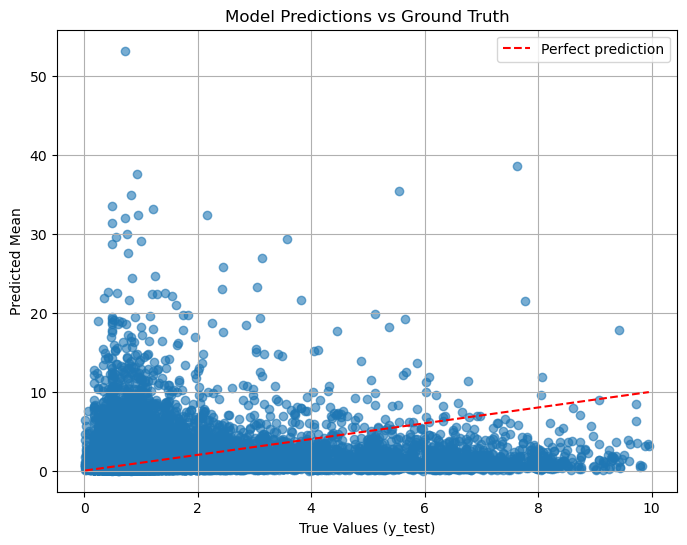

In [61]:
y_pred_log = dist.LogNormal(X_test @ beta_mean, torch.tensor(1.0)).sample()

# Convert to numpy for easy filtering
y_pred_np = y_pred_log.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Define a max value threshold (e.g., 1e6) to clip out extreme values
threshold = 1e1

# Create a valid mask
mask = np.isfinite(y_test_np) & (y_test_np < threshold)

# Apply the mask
y_pred_clean = y_pred_np[mask]
y_test_clean = y_test_np[mask]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_clean, y_pred_clean, alpha=0.6)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], 'r--', label="Perfect prediction")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Mean")
plt.title("Model Predictions vs Ground Truth")
plt.legend()
plt.grid(True)
plt.show()


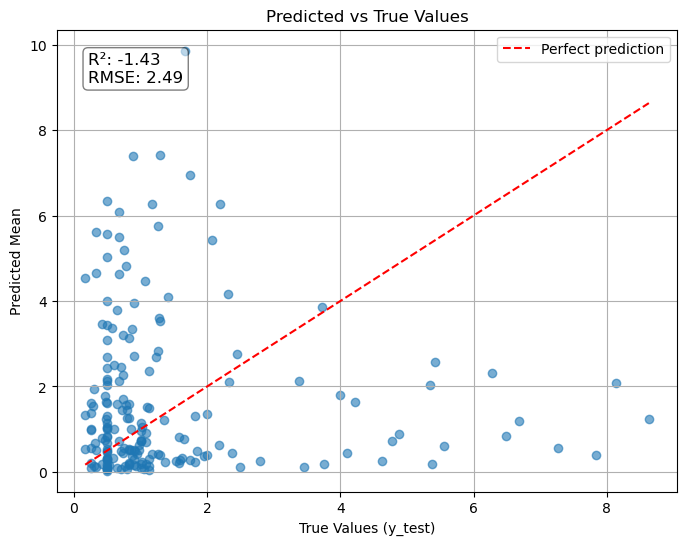

In [34]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Compute metrics
r2 = r2_score(y_test_clean, y_pred_clean)
rmse = mean_squared_error(y_test_clean, y_pred_clean, squared=False)

# Plot with metrics
plt.figure(figsize=(8, 6))
plt.scatter(y_test_clean, y_pred_clean, alpha=0.6)
plt.plot([min(y_test_clean), max(y_test_clean)],
         [min(y_test_clean), max(y_test_clean)],
         'r--', label="Perfect prediction")

plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Mean")
plt.title("Predicted vs True Values")

# Add accuracy metrics
plt.text(0.05, 0.95, f"R²: {r2:.2f}\nRMSE: {rmse:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

plt.legend()
plt.grid(True)
plt.show()


The input to the model is a BERT embedding of the observed variable diagnosis description, $\bm{x}=BERT(diagnosis)$, where $x \in \mathbb{R}^K$.

## PGM using patient profile

In [62]:
import pyro
import pyro.distributions as dist
import torch

def simple_diagnostic(data, y=None):
    P, D = data.shape

    # Prior over weights
    beta = pyro.sample('beta', dist.Normal(0., 1.).expand([D]).to_event(1))
    eta = pyro.sample('eta', dist.Normal(0., 1.).expand([D]).to_event(1))

    with pyro.plate("data", P):
        print(data)
        print(beta)
        loc = (data @ beta)           # shape: (N,)
        scale = torch.abs(data @ eta) + 1e-8  # add epsilon to avoid zero
        v = pyro.sample("v", dist.Normal(loc, scale), obs=y)


In [63]:
df_subset = df[['Patient alder på kontaktstart tidspunkt', 'Patient køn', 'Kontakt varighed (timer)']]
df_subset = df_subset[df_subset['Patient køn'].isin(['Mand', 'Kvinde'])]
df_subset = df_subset.dropna()

# One-hot encode gender
df_subset['is_male'] = (df_subset['Patient køn'] == 'Mand').astype(int)
df_subset['is_female'] = (df_subset['Patient køn'] == 'Kvinde').astype(int)

# Final features: AGE, is_male, is_female
df_subset = df_subset[['Patient alder på kontaktstart tidspunkt', 'is_male', 'is_female', 'Kontakt varighed (timer)']]

In [64]:
from sklearn.model_selection import train_test_split
# Train/test split
train_df, test_df = train_test_split(df_subset, test_size=0.2, random_state=42)
train_data = train_df[['Patient alder på kontaktstart tidspunkt', 'is_male', 'is_female']]
train_y = train_df[['Kontakt varighed (timer)']]

test_data = test_df[['Patient alder på kontaktstart tidspunkt', 'is_male', 'is_female']]
test_y = test_df[['Kontakt varighed (timer)']]

train_tensor = torch.tensor(train_data.to_numpy().astype(np.float32))
train_y_tensor = torch.tensor(train_y.to_numpy().astype(np.float32))
test_tensor = torch.tensor(test_data.to_numpy().astype(np.float32))
test_y_tensor = torch.tensor(test_y.to_numpy().astype(np.float32))

In [65]:
%%time

# Define guide function
#guide = AutoDiagonalNormal(ppca_model)
guide = AutoNormal(simple_diagnostic)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 100

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(simple_diagnostic, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(train_tensor,train_y_tensor)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

tensor([[54.,  0.,  1.],
        [53.,  1.,  0.],
        [68.,  1.,  0.],
        ...,
        [22.,  0.,  1.],
        [82.,  0.,  1.],
        [81.,  0.,  1.]])
tensor([0., 0., 0.])
tensor([[54.,  0.,  1.],
        [53.,  1.,  0.],
        [68.,  1.,  0.],
        ...,
        [22.,  0.,  1.],
        [82.,  0.,  1.],
        [81.,  0.,  1.]])
tensor([ 0.0810, -0.0748, -0.0596], grad_fn=<ExpandBackward0>)


: 

## Topic modelling

In [17]:
def mix_weights(v):
    v1m_cumprod = (1 - v).cumprod(-1)
    return F.pad(v, (0, 1), value=1) * F.pad(v1m_cumprod, (1, 0), value=1)

In [67]:
def model(data, N, K=6, alpha=0.1):
    P, D = data.shape
    
    with pyro.plate("V_plate", K-1):
        V = pyro.sample("V", Beta(1, alpha))

    with pyro.plate("mu_plate", K):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(D), 5*torch.eye(D)))
    
    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(V)))
        obs = pyro.sample("obs", MultivariateNormal(mu[z], 0.1*torch.eye(D)), obs=data)
        
    return z, obs

In [68]:
z, obs = model(embedding_tensor, 200, T=6, alpha=5)

In [77]:
test = np.array(embedding_tensor)

In [56]:
def guide(data, N, T=6, alpha=0.1):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.randn(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("V_plate", T-1):
        q_V = pyro.sample("V", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

torch.Size([4656130, 768])

In [40]:
# Map embeddings
df["embedded"] = df["Aktionsdiagnosekode"].map(code_embeddings)
df = df[df["embedded"].notnull()]

# Convert list of lists to a 2D NumPy array
embeddings = np.array(df["embedded"].tolist(), dtype=np.float32)

# Convert to PyTorch tensor
embedding_tensor = torch.from_numpy(embeddings)

In [ ]:
import pyro
import pyro.distributions as dist
import torch

def simple_diagnostic(data):
    P, D = data.shape

    # Prior over weights
    beta = pyro.sample('beta', dist.Normal(0., 1.).expand([D]).to_event(1))
    eta = pyro.sample('eta', dist.Normal(0., 1.).expand([D]).to_event(1))

    with pyro.plate("data", P):
        print(data)
        print(beta)
        loc = (data @ beta)           # shape: (N,)
        scale = torch.abs(data @ eta) + 1e-8  # add epsilon to avoid zero
        v = pyro.sample("v", dist.Normal(loc, scale))
